# Final Jones polynomial estimates

In [1]:
import joblib

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

In [2]:
#
# there was a bug in our code for the arc-trefoil and 
# arc-trefoil-twist results. It can be corrected by multiplying
# the values in those cases by (+i)
#
jones_factors = {
    'trefoil': 2j,
    'trefoil-twist': 2**4 * (-1/(4*np.sqrt(2))) * np.exp(-1j*7*np.pi/4),
    'arc-trefoil': 1j * 2**2 * (1/(2*np.sqrt(2))) * np.exp(1j*3*np.pi/4),
    'arc-trefoil-twist': 1j * 2**3 * np.exp(1j*np.pi/2) / 4,
}
inflation_factors = {
    'trefoil': 2**3,
    'trefoil-twist': 2**4,
    'arc-trefoil': 2**2,
    'arc-trefoil-twist': 2**3,
}

## Load the data

In [3]:
df = None

for mem_name, mem_fname in zip(['nomem', 'mem'], ['nomem_', '']):
    for knot in ['trefoil', 'trefoil-twist', 'arc-trefoil', 'arc-trefoil-twist']:

        filename = f'{mem_fname}bootstrapped_fits.joblib'
        backends = [
            'ibmq_lima',
            'ibmq_quito',
            'ibmq_paris',
            'ibmq_montreal',
        ]

        # load file
        tmp = joblib.load(f'analysis/fits/{knot}/{filename}')

        # select resample_style
        tmp = tmp.loc[tmp['resample_style'] == 'by_scale_factor']

        # convert from wide to long
        tmp = tmp.rename(
            columns={
                'raw_mean': 'fit_rawmean',
                'lin,3': 'fit_linthree',
                'lin,5': 'fit_linfive',
                'exp,3': 'fit_expthree',
                'exp,7': 'fit_expseven',
            }
        )
        tmp['id'] = tmp.index
        tmp = pd.wide_to_long(
            tmp,
            stubnames=['fit'],
            sep='_',
            i='id',
            j='fitting',
            suffix='\\w+',
        ).reset_index()

        # compress data by taking means and stds
        compressed = tmp.groupby(['fitting', 'part', 'backend_name']).agg({'fit': ['mean', 'std']}).reset_index()
        compressed.columns = ['_'.join(filter(None, col)) for col in compressed.columns]

        # add knot name to data
        compressed['knot'] = knot
        compressed['mem'] = mem_name

        if df is None:
            df = compressed
        else:
            df = pd.concat([df, compressed], ignore_index=True)

In [4]:
df

,fitting,part,backend_name,fit_mean,fit_std,knot,mem
0,rawmean,imag,ibmq_lima,0.436202,0.004213,trefoil,nomem
1,rawmean,imag,ibmq_montreal,0.344202,0.010964,trefoil,nomem
2,rawmean,imag,ibmq_paris,0.358487,0.007970,trefoil,nomem
3,rawmean,imag,ibmq_quito,0.402559,0.006319,trefoil,nomem
4,rawmean,real,ibmq_lima,-0.049557,0.004256,trefoil,nomem
...,...,...,...,...,...,...,...
187,rawmean,imag,ibmq_quito,-0.064085,0.009412,arc-trefoil-twist,mem
188,rawmean,real,ibmq_lima,0.368340,0.003583,arc-trefoil-twist,mem
189,rawmean,real,ibmq_montreal,0.406511,0.006825,arc-trefoil-twist,mem
190,rawmean,real,ibmq_paris,0.409149,0.003109,arc-trefoil-twist,mem


## Plot estimates separated by knot

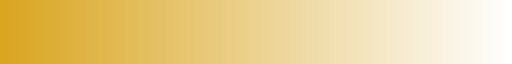

In [6]:
target_colour = 'goldenrod'
mycmap = LinearSegmentedColormap.from_list("mycmap", list(zip([0, 1], [target_colour, 'white'])))
mycmap

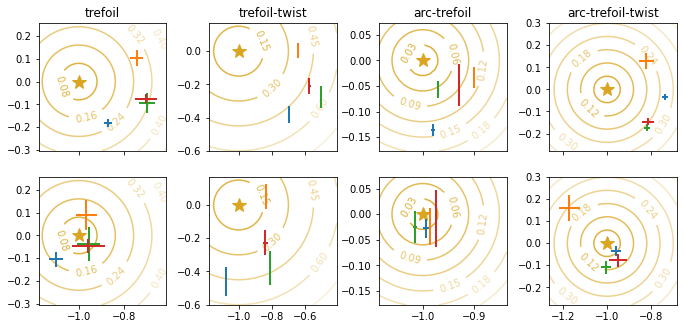

In [9]:
ncols = 4
nrows = 2
fscale = (0.6, 0.6)
fig, grid = plt.subplots(
    ncols=ncols, nrows=nrows, 
    figsize=(ncols*4*fscale[0], nrows*4*fscale[1]),
    sharex='col', sharey='col',
)
# fig.suptitle(f'Jones polynomial estimate for {knot}', fontsize=16)

_row_iterator = list(zip(
    [
        # 'raw',
        'raw_mem',
        'error mitigated',
    ],
    [
        # 'rawmean',
        'rawmean',
        'linthree',
    ],
    [
        # 'nomem',
        'mem',
        'mem',
    ],
))

for cidx, knot in enumerate(['trefoil', 'trefoil-twist', 'arc-trefoil', 'arc-trefoil-twist']):
    
    #     
    # first pass to add data
    #     
    for ridx, (display_name, fitting, mem) in enumerate(_row_iterator):
        
        ax = grid[ridx, cidx]
        ax.set_aspect('equal')
        # ax.grid(alpha=0.2)
        
        for didx, name in enumerate(['ibmq_lima', 'ibmq_quito', 'ibmq_paris', 'ibmq_montreal']):

            _df = df.loc[
                (df['knot'] == knot)
                & (df['backend_name'] == name)
                & (df['fitting'] == fitting)
                & (df['mem'] == mem)
            ]

            real_mean = np.array(_df.loc[
                (df['part'] == 'real')
            ]['fit_mean'])[0]
            real_std = 2 * np.array(_df.loc[
                (df['part'] == 'real')
            ]['fit_std'])[0]

            imag_mean = np.array(_df.loc[
                (df['part'] == 'imag')
            ]['fit_mean'])[0]
            imag_std = 2 * np.array(_df.loc[
                (df['part'] == 'imag')
            ]['fit_std'])[0]

            estimate = (real_mean + 1j * imag_mean) * jones_factors[knot]
            errbar = (real_std + 1j * imag_std) * jones_factors[knot]

            _linewidth = 2.
            ax.errorbar(
                estimate.real, estimate.imag,
                xerr=errbar.real, yerr=errbar.imag,
                label=f'{name}',
                linestyle='',
                capsize=0,
                capthick=_linewidth,
                linewidth=_linewidth,
                zorder=100,
            )

    #     
    # second pass to add contour decoration,
    # also use this to force it to be square
    #     
    
    ax = grid[0, cidx]
    _xmin, _xmax = ax.get_xlim()
    _ymin, _ymax = ax.get_ylim()
    if np.abs(_ymax-_ymin) > np.abs(_xmax-_xmin):
        _padding = np.abs(_ymax-_ymin) - np.abs(_xmax-_xmin)
        _xmin = _xmin - _padding/2.
        _xmax = _xmax + _padding/2.
    else:
        _padding = np.abs(_xmax-_xmin) - np.abs(_ymax-_ymin)
        _ymin = _ymin - _padding/2.
        _ymax = _ymax + _padding/2.
    
    for ridx, (display_name, fitting, mem) in enumerate(_row_iterator):
    
        ax = grid[ridx, cidx]
        ax.plot(-1, 0, '*', markersize=14, color=target_colour)
        
        delta = 0.01
        _eps = (0.02, 0.02)
        x = np.arange(_xmin-_eps[0], _xmax+_eps[0], delta)
        y = np.arange(_ymin-_eps[1], _ymax+_eps[1], delta)
        X, Y = np.meshgrid(x, y)
        Z = np.sqrt((X+1)**2 + Y**2)
        # ax.imshow(
        #     Z, interpolation='bilinear', origin='lower', cmap=mycmap, 
        #     extent=[_xmin-_eps[0], _xmax+_eps[0], _ymin-_eps[1], _ymax+_eps[1]]
        # )
        CS = ax.contour(X, Y, Z, cmap=mycmap)
        ax.clabel(CS, inline=True, fontsize=10)
    
        if ridx == 0:
            ax.set_title(knot)
        if (ridx == nrows-1) and (cidx == ncols-1):
            # ax.legend(bbox_to_anchor=(1., 0.6))
            pass
    
# ax = grid[0, 0]
# _eps = (0.02, 0.02)
# ax.set_xlim(_xmin-_eps[0], _xmax+_eps[0])
# ax.set_ylim(_ymin-_eps[1], _ymax+_eps[1])
# ax.set_xticks([-1.2, -1., -0.8, -0.6])
    
plt.tight_layout()
# plt.savefig('analysis/figs/parts/jones_estimates_contours.pdf')
plt.show()

## Combining knots into a single figue

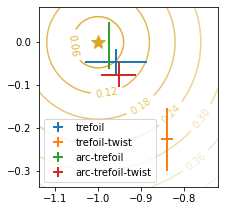

In [11]:
device = 'ibmq_montreal'
knots = ['trefoil', 'trefoil-twist', 'arc-trefoil', 'arc-trefoil-twist']

#
# must run after ABOVE cell to get xmin, xmax, etc.
# 

ncols = 1
nrows = 1
fscale = (0.8, 0.8)
fig, ax = plt.subplots(
    ncols=ncols, nrows=nrows, 
    figsize=(ncols*4*fscale[0], nrows*4*fscale[1]),
    sharex='col', sharey='col',
)
# fig.suptitle(f'Jones polynomial estimate for {knot}', fontsize=16)

ax.set_aspect('equal')
# ax.grid(alpha=0.2)

for didx, knot in enumerate(knots):

    _df = df.loc[
        (df['knot'] == knot)
        & (df['backend_name'] == device)
        & (df['fitting'] == 'linthree')
        & (df['mem'] == 'mem')
    ]

    real_mean = np.array(_df.loc[
        (df['part'] == 'real')
    ]['fit_mean'])[0]
    real_std = 2 * np.array(_df.loc[
        (df['part'] == 'real')
    ]['fit_std'])[0]

    imag_mean = np.array(_df.loc[
        (df['part'] == 'imag')
    ]['fit_mean'])[0]
    imag_std = 2 * np.array(_df.loc[
        (df['part'] == 'imag')
    ]['fit_std'])[0]

    estimate = (real_mean + 1j * imag_mean) * jones_factors[knot]
    errbar = (real_std + 1j * imag_std) * jones_factors[knot]

    _linewidth = 2.
    ax.errorbar(
        estimate.real, estimate.imag,
        xerr=errbar.real, yerr=errbar.imag,
        label=f'{knot}',
        linestyle='',
        capsize=0,
        capthick=_linewidth,
        linewidth=_linewidth,
        zorder=100,
    )

#     
# second pass to add contour decoration,
# also use this to force it to be square
#     

_xmin, _xmax = ax.get_xlim()
_ymin, _ymax = ax.get_ylim()
if np.abs(_ymax-_ymin) > np.abs(_xmax-_xmin):
    _padding = np.abs(_ymax-_ymin) - np.abs(_xmax-_xmin)
    _xmin = _xmin - _padding/2.
    _xmax = _xmax + _padding/2.
else:
    _padding = np.abs(_xmax-_xmin) - np.abs(_ymax-_ymin)
    _ymin = _ymin - _padding/2.
    _ymax = _ymax + _padding/2.

ax.plot(-1, 0, '*', markersize=14, color=target_colour)

delta = 0.01
_eps = (0.02, 0.02)
x = np.arange(_xmin-_eps[0], _xmax+_eps[0], delta)
y = np.arange(_ymin-_eps[1], _ymax+_eps[1], delta)
X, Y = np.meshgrid(x, y)
Z = np.sqrt((X+1)**2 + Y**2)
# ax.imshow(
#     Z, interpolation='bilinear', origin='lower', cmap=mycmap, 
#     extent=[_xmin-_eps[0], _xmax+_eps[0], _ymin-_eps[1], _ymax+_eps[1]]
# )
CS = ax.contour(X, Y, Z, cmap=mycmap)
ax.clabel(CS, inline=True, fontsize=10)

# ax = grid[0, 0]
# _eps = (0.02, 0.02)
# ax.set_xlim(_xmin-_eps[0], _xmax+_eps[0])
# ax.set_ylim(_ymin-_eps[1], _ymax+_eps[1])
# ax.set_xticks([-1.2, -1., -0.8, -0.6])
    
plt.legend()
    
plt.tight_layout()
# plt.savefig('analysis/figs/parts/jones_estimates_contours_knots_comparison.pdf')
plt.show()